In [51]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [52]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0
nfreq = 1

In [184]:
tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 0.5 * 2
monitor_blank = 0.5 * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = round(width_ag + width_sio2 + width_ag,2)
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1  # 평면 구조


# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    # mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y)
]

In [185]:
# 셀 크기 설정
decom_size = width_bot_ag*3
cell_size = mp.Vector3(decom_size, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [186]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,

        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [187]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]


k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        k_point=k0
    )
    for src in sources
]

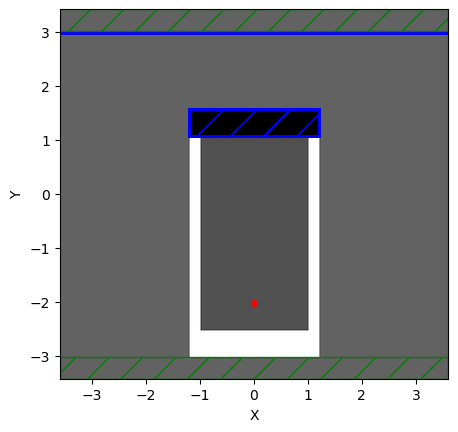

In [188]:
monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(decom_size, 0)

FourierFields_list = [
    mpa.FourierFields(
        sims[i],  
        mp.Volume(center=monitor_position_J, size=monitor_size),
        mp.Ez,
        yee_grid=True
    )
    for i in range(num_sources)
]

# def J(fields):
#     k0   = 2*npa.pi*fcen
#     lam0 = 1.0/fcen
#     L    = float(monitor_size.x)

#     ref_theta = 30

#     th1, th2 = npa.deg2rad(-ref_theta), npa.deg2rad(+45.0)
#     dth      = lam0/(L + 1e-18)
#     Nth      = int(np.ceil((float(th2 - th1))/float(dth))) + 1
#     theta    = npa.linspace(th1, th2, Nth)
#     kx       = k0 * npa.sin(theta)
#     dtheta   = (th2 - th1) / (Nth - 1 + 1e-12)

#     FoM = 0.0
#     for f in fields:
#         E  = npa.ravel(f)                 
#         N  = E.size
#         Lx = L; dx = Lx/N
#         x  = npa.linspace(-Lx/2, Lx/2 - dx, N)
#         C  = dx * npa.sum(E[None,:] * npa.exp(-1j*kx[:,None]*x[None,:]), axis=1)
#         Pθ = (npa.abs(C)**2) * npa.cos(theta)
#         FoM += npa.sum(Pθ) * dtheta

#     return FoM

# def J(fields):
#     k0   = 2*npa.pi*fcen
#     lam0 = 1.0/fcen
#     L    = float(monitor_size.x)

#     ref_theta = 30
#     th1, th2  = npa.deg2rad(-ref_theta), npa.deg2rad(ref_theta)

#     # 샘플 수는 기존 방식 유지(각도 해상도 ~ λ0/L) — FoM엔 곱하지 않음
#     dth  = lam0/(L + 1e-18)
#     Nth  = int(np.ceil((float(th2 - th1))/float(dth))) + 1
#     theta = npa.linspace(th1, th2, Nth)
#     kx    = k0 * npa.sin(theta)

#     FoM = 0.0
#     for f in fields:
#         E  = npa.ravel(f)                 # (N,) 복소장 (라인 모니터)
#         N  = E.size
#         Lx = L; dx = Lx/N
#         x  = npa.linspace(-Lx/2, Lx/2 - dx, N)

#         # 연속 투영에서 dx 계수도 제거 → 순수한 합(스케일 고정치 제거)
#         C  = npa.sum(E[None,:] * npa.exp(-1j*kx[:,None]*x[None,:]), axis=1)

#         # 분모/스텝(Δθ) 없이 코사인 가중만 적용해 합산
#         Pθ = (npa.abs(C)**2) * npa.cos(theta)
#         FoM += npa.sum(Pθ)

#     return FoM

# def J(fields):
#     k0   = 2*npa.pi*fcen
#     lam0 = 1.0/fcen
#     L    = float(monitor_size.x)

#     ref_theta = 30.0
#     th1, th2  = npa.deg2rad(-ref_theta), npa.deg2rad(ref_theta)

#     # 각도 샘플 (Δθ≈λ0/L) — FoM에는 곱하지 않음
#     dth   = lam0/(L + 1e-18)
#     Nth   = int(npa.ceil((float(th2 - th1))/float(dth))) + 1
#     theta = npa.linspace(th1, th2, Nth)
#     kx    = k0 * npa.sin(theta)

#     # ---- 중앙 편향 가중 및 소프트 윈도우 ----
#     gamma      = 2.0    # cos(θ)^γ : 정면 우대 강화
#     sigma_deg  = 8.0    # 중앙(0°) 가우시안 폭
#     alpha      = 0.3    # 기본(균일) 비중: 0~1 (클수록 전체 전력도 챙김)
#     edge_deg   = 3.0    # 경계 테이퍼 폭(부드럽게 0으로)

#     # (1) 소프트 박스창 w_soft : |θ| ≤ refθ에서 1, 경계 edge에서 cos-테이퍼
#     edge  = npa.deg2rad(edge_deg)
#     th_lo, th_hi = th1, th2
#     w_core = (theta >= (th_lo+edge)) * (theta <= (th_hi-edge))
#     w_lo   = (theta >= th_lo) * (theta < (th_lo+edge)) * 0.5*(1 - npa.cos(npa.pi*(theta-th_lo)/edge))
#     w_hi   = (theta >  (th_hi-edge)) * (theta <= th_hi)   * 0.5*(1 - npa.cos(npa.pi*(th_hi-theta)/edge))
#     w_soft = w_core + w_lo + w_hi

#     # (2) 중앙 가우시안 타깃 T_center (0°에 더 큰 가중)
#     T_center = npa.exp(-(theta / npa.deg2rad(sigma_deg))**2)

#     # (3) 최종 각도 가중 W(θ)
#     W = w_soft * (alpha + (1.0 - alpha) * T_center)

#     FoM = 0.0
#     for f in fields:
#         E  = npa.ravel(f)                 # (N,) 복소장
#         N  = E.size
#         Lx = L; dx = Lx/N
#         x  = npa.linspace(-Lx/2, Lx/2 - dx, N)

#         # 라인-DFT 투영 (스케일 고정 위해 dx 미곱)
#         C  = npa.sum(E[None,:] * npa.exp(-1j*kx[:,None]*x[None,:]), axis=1)

#         # 각도 전력 + 정면 우대 + 가중창
#         Pθ = (npa.abs(C)**2) * (npa.cos(theta)**gamma)
#         FoM += npa.sum(Pθ * W)

#     return FoM

def J(fields):
    k0   = 2*npa.pi*fcen
    lam0 = 1.0/fcen
    L    = float(monitor_size.x)

    ref_theta = 45.0
    th1, th2  = npa.deg2rad(-ref_theta), npa.deg2rad(ref_theta)

    dth   = lam0/(L + 1e-18)
    Nth   = int(npa.ceil((float(th2 - th1))/float(dth))) + 1
    theta = npa.linspace(th1, th2, Nth)
    kx    = k0 * npa.sin(theta)

    gamma      = 1.5    # 정면 우대(너무 크지 않게)
    alpha      = 0.7    # 균일(전체 전력) 비중 ↑ : 0.7~0.9 권장
    sigma_deg  = 8.0    # 정면 보너스 폭(약하게 유지)
    edge_deg   = 3.0    # 경계 테이퍼(수렴 안정)
    lambda_flat = 1e-3  # 피크 억제(평탄화) 패널티

    edge  = npa.deg2rad(edge_deg)
    th_lo, th_hi = th1, th2
    w_core = (theta >= (th_lo+edge)) * (theta <= (th_hi-edge))
    w_lo   = (theta >= th_lo) * (theta < (th_lo+edge)) * 0.5*(1 - npa.cos(npa.pi*(theta-th_lo)/edge))
    w_hi   = (theta >  (th_hi-edge)) * (theta <= th_hi)   * 0.5*(1 - npa.cos(npa.pi*(th_hi-theta)/edge))
    w_soft = w_core + w_lo + w_hi

    T_center = npa.exp(-(theta / npa.deg2rad(sigma_deg))**2)

    W = w_soft * (alpha + (1.0 - alpha) * T_center)

    FoM = 0.0
    for f in fields:
        E  = npa.ravel(f)
        N  = E.size
        Lx = L; dx = Lx/N
        x  = npa.linspace(-Lx/2, Lx/2 - dx, N)
        C  = npa.sum(E[None,:] * npa.exp(-1j*kx[:,None]*x[None,:]), axis=1)
        Pθ = (npa.abs(C)**2) * (npa.cos(theta)**gamma)
        term_gain = npa.sum(Pθ * W)
        term_flat = - lambda_flat * npa.sum((Pθ * w_soft)**2)
        FoM += term_gain + term_flat

    return FoM


opt_list = [
    mpa.OptimizationProblem(
        simulation=sims[i],
        objective_functions=[J],
        objective_arguments=[FourierFields_list[i]],
        design_regions=[design_region],  
        frequencies=[fcen],
        maximum_run_time=100,
    )
    for i in range(num_sources)
]
for i in range(num_sources):
    opt_list[i].plot2D(True)

In [179]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
        
    def reset_momenta(self):
        self.mt = None
        self.vt = None
        self.iter = 0
        
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [180]:
eta_i = 0.5

def multi_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)


In [ ]:
# def conic_filter_1d(field, filter_radius, design_region_width, design_region_resolution, periodic=False):
#     import numpy as np
#     from autograd import numpy as npa

#     twoD_col = (field.ndim == 2 and field.shape[1] == 1)
#     f = field[:,0] if twoD_col else field
#     Nx = int(f.shape[0])

#     dx   = 1.0 / float(design_region_resolution)
#     Rpix = int(max(1, round(float(filter_radius) / dx)))

#     k = np.arange(-Rpix, Rpix + 1, dtype=int)
#     w = np.maximum(0.0, 1.0 - np.abs(k) / float(Rpix))  # (2*R+1,)

#     # 컨볼루션 행렬
#     W = np.zeros((Nx, Nx), dtype=float)
#     if periodic:
#         for i in range(Nx):
#             idx = (i + k) % Nx
#             W[i, idx] += w
#     else:
#         for i in range(Nx):
#             idx = i + k
#             mask = (idx >= 0) & (idx < Nx)
#             W[i, idx[mask]] += w[mask]

#     ones  = npa.ones((Nx,))
#     Wnpa  = npa.array(W)
#     denom = npa.dot(Wnpa, ones) + 1e-12
#     num   = npa.dot(Wnpa, f)
#     y     = num / denom

#     if twoD_col:
#         y = y.reshape(Nx, 1)
#     return y  


In [ ]:
# eta_i = 0.5
# minimum_length = 0.09
# eta_e = 0.55

# filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)


# def multi_mapping(x, eta, beta):
#     size_each = Nx * Ny
#     v3 = x.reshape(layer_num, size_each)

#     rho_list = []
#     for i in range(layer_num):
#         layer_field = v3[i].reshape(Nx, Ny)  # (Nx,1) 가정

#         # 1D 코닉 필터 (출력: (Nx,1))
#         filtered_field = conic_filter_1d(
#             layer_field,
#             filter_radius,
#             design_region_width,
#             design_region_resolution,
#             periodic=False
#         )

#         # 투영
#         projected_field = mpa.tanh_projection(filtered_field, beta, eta)

#         # 대칭
#         sym_field = (projected_field[::-1, :] + projected_field) / 2

#         # 모양 방어적 체크 (디버깅용)
#         if sym_field is None:
#             raise RuntimeError("sym_field is None inside multi_mapping")
#         if sym_field.shape != (Nx, Ny):
#             raise RuntimeError(f"sym_field shape {sym_field.shape} != {(Nx, Ny)}")

#         rho_list.append(sym_field.ravel())

#     out = npa.concatenate(rho_list, axis=0)
#     if out is None:
#         raise RuntimeError("multi_mapping is returning None (concatenate failed)")
#     return out



In [144]:
def ramp_beta_once(beta):
    # 기존 규칙을 "한 스텝"만 진행하도록 랩핑
    if beta < 8:
        return beta * 1.2  # 1.3 → 1.2로 완화(원하면 조절)
    else:
        return beta + 5*np.tanh((beta - 0.5)*0.02)

In [181]:
n = Nx * layer_num
np.random.seed(5)           
x = 0.4 + 0.2 * np.random.rand(n)  
# x = np.ones(n)*0.5

cur_beta = 4

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

# optimizers = [AdamOptimizer(lr=0.005, beta1=0.8) for _ in range(layer_num)]
optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny
    rho_list = [rho_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]

    f0_list = []
    dJ_list = []
    for i in range(len(opt_list)):
        f0_i, dJ_i = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
        f0_list.append(f0_i.flatten())
        dJ_list.append(dJ_i)

    dJ_total = np.mean(dJ_list, axis=0) # -> 3번째 트라이 바꾸는 부분
    dJ_flat = np.array(dJ_total).flatten()

    gradient_full = tensor_jacobian_product(multi_mapping, 0)(v, eta, beta, dJ_flat)
    g_norm = np.linalg.norm(gradient_full.ravel()) / np.sqrt(gradient_full.size) + 1e-12
    gradient_full = gradient_full / g_norm

    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)

        if not hasattr(optimizers[i], "base_lr"):
            optimizers[i].base_lr = optimizers[i].lr
        if optimizers[i].lr < optimizers[i].base_lr:
            optimizers[i].lr = min(optimizers[i].base_lr, optimizers[i].lr * 1.25)
    v_new = np.concatenate(v_new_layers)

    f_vals = [float(np.abs(f0).item()) for f0 in f0_list]
    evaluation_history.append(f_vals)

    beta_history.append(beta)
    cur_iter[0] += 1

    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        # FoM 기준 변화율 계산 (여기 부분 계속 수정중)
        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.005 and change2 < 0.005) and (bin_change1 < 0.001 and bin_change2 < 0.001):
            if beta < 8:
                beta *= 1.3
            else:
                beta = beta + 5*np.tanh((beta - 0.5)*0.02)

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")

    print(f"Binarization degree: {bin_deg:.4f}")

    # plt.figure(figsize=(3, 2))
    # ax = plt.gca()
    # opt_list[0].plot2D(
    #     False,
    #     output_plane=mp.Volume(
    #         size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
    #         center=mp.Vector3(0, full_center_y, 0)
    #     ),
    #     ax=ax,
    #     show_sources=False,
    #     show_monitors=False,
    #     show_boundary_layers=False,
    # )
    # ax.axis("off")
    # plt.show()

    return v_new, beta

mp.verbosity(0)
Max_iter = 150

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.99:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        print("FOM increases : ", )
        break


--- Iter 1 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1573.9920853658728]
Mean FoM: 1573.992085
Binarization degree: 0.1677

--- Iter 2 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1700.7151020731167]
Mean FoM: 1700.715102
Binarization degree: 0.1683

--- Iter 3 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1704.9629531915448]
Mean FoM: 1704.962953
Binarization degree: 0.1707

--- Iter 4 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1703.2417023184726]
Mean FoM: 1703.241702
Binarization degree: 0.1721

--- Iter 5 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1909.9857507595827]
Mean FoM: 1909.985751
Binarization degree: 0.1731

--- Iter 6 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2195.6823399591212]
Mean FoM: 2195.682340
Binarization degree: 0.1746

--- Iter 7 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2345.362422295013]
Mean FoM: 2345.362422
Binarization degree: 0.1776

--- Iter 8 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2495.313519542862]
Mean FoM: 2495.313520
Binarization degree: 0.1857

--- Iter 9 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2463.019600747308]
Mean FoM: 2463.019601
Binarization degree: 0.1991

--- Iter 10 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2453.7649595754556]
Mean FoM: 2453.764960
Binarization degree: 0.2122

--- Iter 11 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2501.517080298289]
Mean FoM: 2501.517080
Binarization degree: 0.2254

--- Iter 12 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2522.100713320612]
Mean FoM: 2522.100713
Binarization degree: 0.2383

--- Iter 13 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2536.8014869326626]
Mean FoM: 2536.801487
Binarization degree: 0.2504

--- Iter 14 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2592.3742203299485]
Mean FoM: 2592.374220
Binarization degree: 0.2608

--- Iter 15 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2594.167219213218]
Mean FoM: 2594.167219
Binarization degree: 0.2716

--- Iter 16 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2599.100963609072]
Mean FoM: 2599.100964
Binarization degree: 0.2807

--- Iter 17 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2636.0121462883744]
Mean FoM: 2636.012146
Binarization degree: 0.2877

--- Iter 18 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2681.1224487976046]
Mean FoM: 2681.122449
Binarization degree: 0.2933

--- Iter 19 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2698.0663106550246]
Mean FoM: 2698.066311
Binarization degree: 0.2981

--- Iter 20 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2673.8246588812444]
Mean FoM: 2673.824659
Binarization degree: 0.3044

--- Iter 21 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2706.1024846726186]
Mean FoM: 2706.102485
Binarization degree: 0.3111

--- Iter 22 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2726.976865336064]
Mean FoM: 2726.976865
Binarization degree: 0.3174

--- Iter 23 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2734.0344382456487]
Mean FoM: 2734.034438
Binarization degree: 0.3226

--- Iter 24 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2756.6516939644384]
Mean FoM: 2756.651694
Binarization degree: 0.3272

--- Iter 25 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2773.3367850390096]
Mean FoM: 2773.336785
Binarization degree: 0.3318

--- Iter 26 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2787.17978594197]
Mean FoM: 2787.179786
Binarization degree: 0.3391

--- Iter 27 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2806.785928522192]
Mean FoM: 2806.785929
Binarization degree: 0.3480

--- Iter 28 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2822.300257118562]
Mean FoM: 2822.300257
Binarization degree: 0.3578

--- Iter 29 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2831.8963874579463]
Mean FoM: 2831.896387
Binarization degree: 0.3671

--- Iter 30 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2845.981433293521]
Mean FoM: 2845.981433
Binarization degree: 0.3747

--- Iter 31 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2881.018650275386]
Mean FoM: 2881.018650
Binarization degree: 0.3805

--- Iter 32 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2925.6181055350735]
Mean FoM: 2925.618106
Binarization degree: 0.3853

--- Iter 33 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2940.0540579268236]
Mean FoM: 2940.054058
Binarization degree: 0.3899

--- Iter 34 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2931.959291366163]
Mean FoM: 2931.959291
Binarization degree: 0.3942

--- Iter 35 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2943.5368379189495]
Mean FoM: 2943.536838
Binarization degree: 0.4000

--- Iter 36 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2979.7829330616873]
Mean FoM: 2979.782933
Binarization degree: 0.4061

--- Iter 37 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3005.4528839929826]
Mean FoM: 3005.452884
Binarization degree: 0.4116

--- Iter 38 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3018.3413029378494]
Mean FoM: 3018.341303
Binarization degree: 0.4168

--- Iter 39 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3013.16715309441]
Mean FoM: 3013.167153
Binarization degree: 0.4210

--- Iter 40 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3014.058175933577]
Mean FoM: 3014.058176
Binarization degree: 0.4249

--- Iter 41 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3035.1234746714285]
Mean FoM: 3035.123475
Binarization degree: 0.4296

--- Iter 42 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3037.989505160662]
Mean FoM: 3037.989505
Binarization degree: 0.4339

--- Iter 43 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3042.175843837511]
Mean FoM: 3042.175844
Binarization degree: 0.4390

--- Iter 44 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3058.2461366476296]
Mean FoM: 3058.246137
Binarization degree: 0.4442

--- Iter 45 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3049.417896599061]
Mean FoM: 3049.417897
Binarization degree: 0.4493

--- Iter 46 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3060.8927326529256]
Mean FoM: 3060.892733
Binarization degree: 0.4534

--- Iter 47 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3081.4128688038513]
Mean FoM: 3081.412869
Binarization degree: 0.4565

--- Iter 48 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3086.5271550517514]
Mean FoM: 3086.527155
Binarization degree: 0.4591

--- Iter 49 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3086.160063217485]
Mean FoM: 3086.160063
Binarization degree: 0.4633

--- Iter 50 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3088.16887373234]
Mean FoM: 3088.168874
Binarization degree: 0.4677

--- Iter 51 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3086.199435527691]
Mean FoM: 3086.199436
Binarization degree: 0.4717

--- Iter 52 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3095.6969026782463]
Mean FoM: 3095.696903
Binarization degree: 0.4753

--- Iter 53 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3094.1333370042976]
Mean FoM: 3094.133337
Binarization degree: 0.4792

--- Iter 54 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3079.4523109315246]
Mean FoM: 3079.452311
Binarization degree: 0.4839

--- Iter 55 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3083.6693107100195]
Mean FoM: 3083.669311
Binarization degree: 0.4887

--- Iter 56 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3079.08782102999]
Mean FoM: 3079.087821
Binarization degree: 0.4940

--- Iter 57 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3087.598812648401]
Mean FoM: 3087.598813
Binarization degree: 0.4992

--- Iter 58 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3080.610209185873]
Mean FoM: 3080.610209
Binarization degree: 0.5045

--- Iter 59 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3078.6126989190248]
Mean FoM: 3078.612699
Binarization degree: 0.5096

--- Iter 60 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3102.0248016658697]
Mean FoM: 3102.024802
Binarization degree: 0.5144

--- Iter 61 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3088.271926825669]
Mean FoM: 3088.271927
Binarization degree: 0.5195

--- Iter 62 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3093.790054594401]
Mean FoM: 3093.790055
Binarization degree: 0.5246

--- Iter 63 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3101.864490713849]
Mean FoM: 3101.864491
Binarization degree: 0.5303

--- Iter 64 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3102.048281979241]
Mean FoM: 3102.048282
Binarization degree: 0.5353

--- Iter 65 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3111.0448638591834]
Mean FoM: 3111.044864
Binarization degree: 0.5393

--- Iter 66 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3073.944532856112]
Mean FoM: 3073.944533
Binarization degree: 0.5423

--- Iter 67 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3042.880682287959]
Mean FoM: 3042.880682
Binarization degree: 0.5454

--- Iter 68 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3085.3847225363775]
Mean FoM: 3085.384723
Binarization degree: 0.5486

--- Iter 69 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3108.646471581063]
Mean FoM: 3108.646472
Binarization degree: 0.5521

--- Iter 70 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3069.8007754235527]
Mean FoM: 3069.800775
Binarization degree: 0.5553

--- Iter 71 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3035.4772894974]
Mean FoM: 3035.477289
Binarization degree: 0.5585

--- Iter 72 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3065.5403141291135]
Mean FoM: 3065.540314
Binarization degree: 0.5617

--- Iter 73 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3102.0855203564065]
Mean FoM: 3102.085520
Binarization degree: 0.5647

--- Iter 74 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3100.025163920392]
Mean FoM: 3100.025164
Binarization degree: 0.5674

--- Iter 75 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3052.498246040531]
Mean FoM: 3052.498246
Binarization degree: 0.5699

--- Iter 76 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3076.3618399994343]
Mean FoM: 3076.361840
Binarization degree: 0.5724

--- Iter 77 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3099.213037895347]
Mean FoM: 3099.213038
Binarization degree: 0.5750

--- Iter 78 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3111.4440568896794]
Mean FoM: 3111.444057
Binarization degree: 0.5778

--- Iter 79 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3103.2632081061765]
Mean FoM: 3103.263208
Binarization degree: 0.5801

--- Iter 80 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3092.75202032274]
Mean FoM: 3092.752020
Binarization degree: 0.5821

--- Iter 81 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3099.3110481701333]
Mean FoM: 3099.311048
Binarization degree: 0.5838

--- Iter 82 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3115.128863742394]
Mean FoM: 3115.128864
Binarization degree: 0.5851

--- Iter 83 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3086.435664751321]
Mean FoM: 3086.435665
Binarization degree: 0.5860

--- Iter 84 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3017.6991031205825]
Mean FoM: 3017.699103
Binarization degree: 0.5871

--- Iter 85 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3035.6269267148787]
Mean FoM: 3035.626927
Binarization degree: 0.5882

--- Iter 86 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3064.8549511385777]
Mean FoM: 3064.854951
Binarization degree: 0.5896

--- Iter 87 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3086.1403283603922]
Mean FoM: 3086.140328
Binarization degree: 0.5915

--- Iter 88 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3092.6700606017002]
Mean FoM: 3092.670061
Binarization degree: 0.5937

--- Iter 89 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3086.878506787283]
Mean FoM: 3086.878507
Binarization degree: 0.5959

--- Iter 90 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3089.1160920375773]
Mean FoM: 3089.116092
Binarization degree: 0.5982

--- Iter 91 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3083.792363833206]
Mean FoM: 3083.792364
Binarization degree: 0.6003

--- Iter 92 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3096.3749278925757]
Mean FoM: 3096.374928
Binarization degree: 0.6019

--- Iter 93 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3099.47039698059]
Mean FoM: 3099.470397
Binarization degree: 0.6031

--- Iter 94 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3050.2389459978717]
Mean FoM: 3050.238946
Binarization degree: 0.6046

--- Iter 95 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3079.8506032765367]
Mean FoM: 3079.850603
Binarization degree: 0.6058

--- Iter 96 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3112.2082353224114]
Mean FoM: 3112.208235
Binarization degree: 0.6073

--- Iter 97 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3116.4538374812237]
Mean FoM: 3116.453837
Binarization degree: 0.6090

--- Iter 98 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3117.3969148252677]
Mean FoM: 3117.396915
Binarization degree: 0.6102

--- Iter 99 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3115.2973440575824]
Mean FoM: 3115.297344
Binarization degree: 0.6108

--- Iter 100 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3117.4311907220203]
Mean FoM: 3117.431191
Binarization degree: 0.6116

--- Iter 101 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3122.6713783260893]
Mean FoM: 3122.671378
Binarization degree: 0.6122

--- Iter 102 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3106.0848570461576]
Mean FoM: 3106.084857
Binarization degree: 0.6134

--- Iter 103 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3060.4520629822914]
Mean FoM: 3060.452063
Binarization degree: 0.6143

--- Iter 104 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3073.080330738051]
Mean FoM: 3073.080331
Binarization degree: 0.6150

--- Iter 105 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3104.1020399776917]
Mean FoM: 3104.102040
Binarization degree: 0.6154

--- Iter 106 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3119.451184864277]
Mean FoM: 3119.451185
Binarization degree: 0.6160

--- Iter 107 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3110.7313637359734]
Mean FoM: 3110.731364
Binarization degree: 0.6170

--- Iter 108 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3102.0716426844588]
Mean FoM: 3102.071643
Binarization degree: 0.6181

--- Iter 109 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3107.0765107769857]
Mean FoM: 3107.076511
Binarization degree: 0.6192

--- Iter 110 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3117.430771994017]
Mean FoM: 3117.430772
Binarization degree: 0.6200

--- Iter 111 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [3125.0296825573705]
Mean FoM: 3125.029683
Binarization degree: 0.6203

--- Iter 112 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3119.957185417976]
Mean FoM: 3119.957185
Binarization degree: 0.6207

--- Iter 113 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [2843.1851631377804]
Mean FoM: 2843.185163
Binarization degree: 0.6892

--- Iter 114 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [2903.4951555802304]
Mean FoM: 2903.495156
Binarization degree: 0.6904

--- Iter 115 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [2984.5017967588165]
Mean FoM: 2984.501797
Binarization degree: 0.6925

--- Iter 116 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3034.7543958670326]
Mean FoM: 3034.754396
Binarization degree: 0.6947

--- Iter 117 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3041.5014983663623]
Mean FoM: 3041.501498
Binarization degree: 0.6950

--- Iter 118 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3049.4280111087087]
Mean FoM: 3049.428011
Binarization degree: 0.6931

--- Iter 119 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3074.5315545381663]
Mean FoM: 3074.531555
Binarization degree: 0.6894

--- Iter 120 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3089.635274051142]
Mean FoM: 3089.635274
Binarization degree: 0.6846

--- Iter 121 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3106.335264665768]
Mean FoM: 3106.335265
Binarization degree: 0.6795

--- Iter 122 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3109.160483080897]
Mean FoM: 3109.160483
Binarization degree: 0.6744

--- Iter 123 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3100.2454273205362]
Mean FoM: 3100.245427
Binarization degree: 0.6727

--- Iter 124 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3055.086741978426]
Mean FoM: 3055.086742
Binarization degree: 0.6720

--- Iter 125 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3027.531131375118]
Mean FoM: 3027.531131
Binarization degree: 0.6723

--- Iter 126 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [2930.8554252000467]
Mean FoM: 2930.855425
Binarization degree: 0.6732

--- Iter 127 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3026.578656725024]
Mean FoM: 3026.578657
Binarization degree: 0.6734

--- Iter 128 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3048.2619591400457]
Mean FoM: 3048.261959
Binarization degree: 0.6738

--- Iter 129 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3051.617613968988]
Mean FoM: 3051.617614
Binarization degree: 0.6765

--- Iter 130 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3081.4659608450343]
Mean FoM: 3081.465961
Binarization degree: 0.6807

--- Iter 131 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [2959.3684498240864]
Mean FoM: 2959.368450
Binarization degree: 0.6868

--- Iter 132 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [2839.3648822053624]
Mean FoM: 2839.364882
Binarization degree: 0.6922

--- Iter 133 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3011.8740409061]
Mean FoM: 3011.874041
Binarization degree: 0.6962

--- Iter 134 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3106.3089051625902]
Mean FoM: 3106.308905
Binarization degree: 0.6988

--- Iter 135 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3102.74201720944]
Mean FoM: 3102.742017
Binarization degree: 0.7017

--- Iter 136 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3116.7065455360175]
Mean FoM: 3116.706546
Binarization degree: 0.7048

--- Iter 137 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3102.7897936654635]
Mean FoM: 3102.789794
Binarization degree: 0.7071

--- Iter 138 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3087.1025588341467]
Mean FoM: 3087.102559
Binarization degree: 0.7091

--- Iter 139 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3087.218253094447]
Mean FoM: 3087.218253
Binarization degree: 0.7112

--- Iter 140 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3090.198533125535]
Mean FoM: 3090.198533
Binarization degree: 0.7130

--- Iter 141 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3102.9624863670992]
Mean FoM: 3102.962486
Binarization degree: 0.7141

--- Iter 142 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3121.5673076418707]
Mean FoM: 3121.567308
Binarization degree: 0.7141

--- Iter 143 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3119.806840277816]
Mean FoM: 3119.806840
Binarization degree: 0.7129

--- Iter 144 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.200
FoM values: [3108.6860694319143]
Mean FoM: 3108.686069
Binarization degree: 0.7125

--- Iter 145 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.760
FoM values: [3109.7165883417842]
Mean FoM: 3109.716588
Binarization degree: 0.7119

--- Iter 146 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.760
FoM values: [3021.920432114525]
Mean FoM: 3021.920432
Binarization degree: 0.7733

--- Iter 147 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.760
FoM values: [3038.2420530256404]
Mean FoM: 3038.242053
Binarization degree: 0.7727

--- Iter 148 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.760
FoM values: [3084.8299447184804]
Mean FoM: 3084.829945
Binarization degree: 0.7722

--- Iter 149 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.760
FoM values: [3108.127512803418]
Mean FoM: 3108.127513
Binarization degree: 0.7722

--- Iter 150 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 6.760
FoM values: [3110.4739774939408]
Mean FoM: 3110.473977
Binarization degree: 0.7734


최대 FoM = 3125.029683 는 iteration 111 에서 나왔습니다.


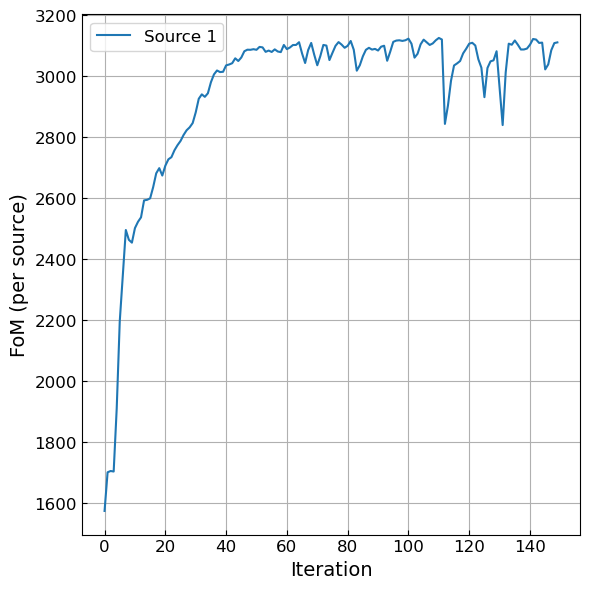

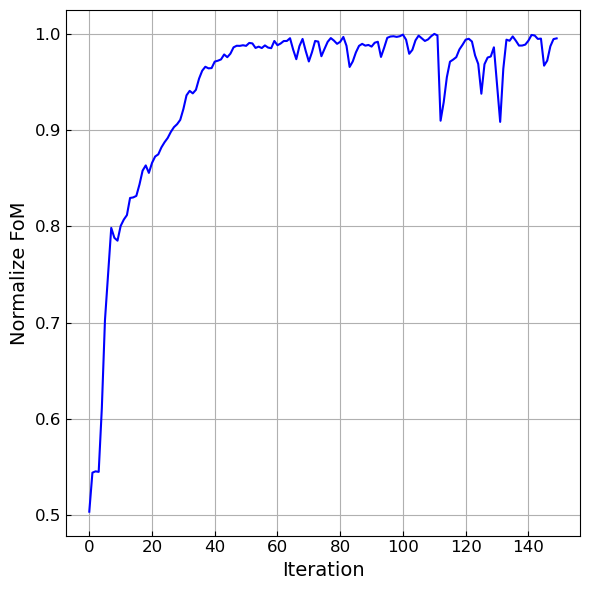

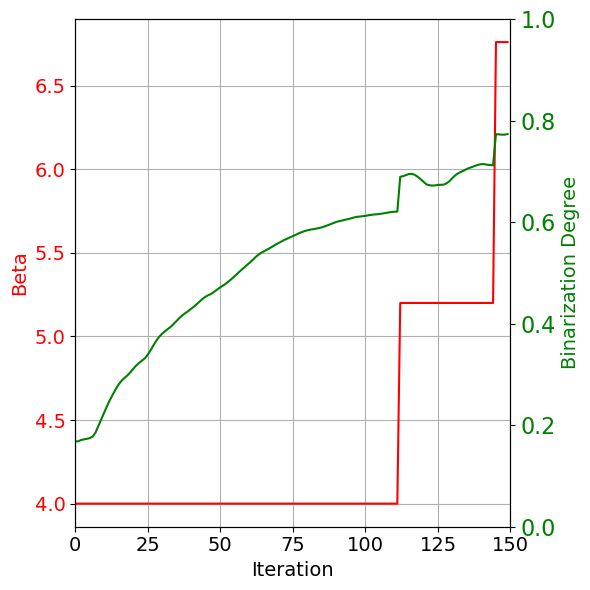

In [182]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
evaluation_array = np.array(evaluation_history)  
iterations = np.arange(len(evaluation_history))

###################### [1] 각 소스별 FoM plot ######################
plt.figure(figsize=(6, 6))

for i in range(evaluation_array.shape[1]):  # 각 소스별
    plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('FoM (per source)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###################### [2] 평균 FoM plot ######################
plt.figure(figsize=(6, 6))

mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
plt.plot(iterations, mean_fom/max(mean_fom), 'b-', label='Mean FoM')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Normalize FoM', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.tight_layout()
plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()

In [189]:
# # k = design_variables.weights
# # np.savetxt("Objective45_third.txt", k) 

# k = np.loadtxt("Objective45_third.txt")
# opt_list[0].update_design([k])

# k = design_variables.weights
# np.savetxt("Objective45_BEST.txt", k) 

k = np.loadtxt("Objective45_BEST.txt")
opt_list[0].update_design([k])

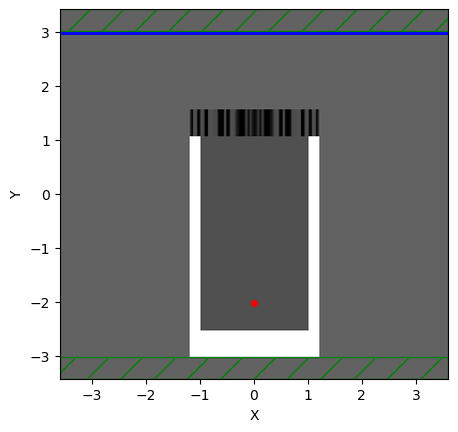

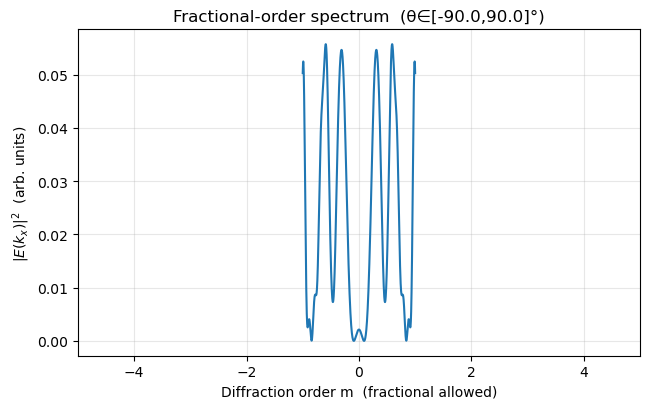

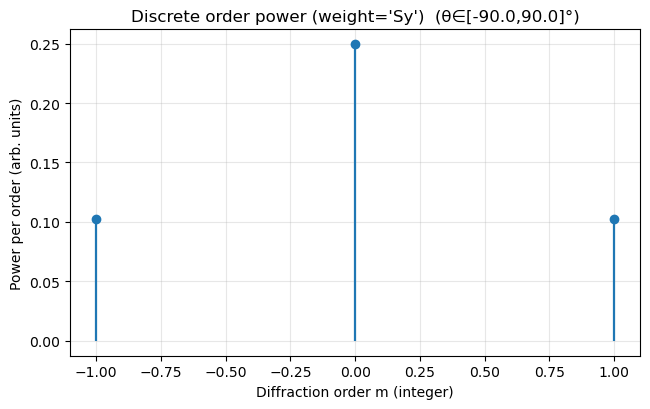

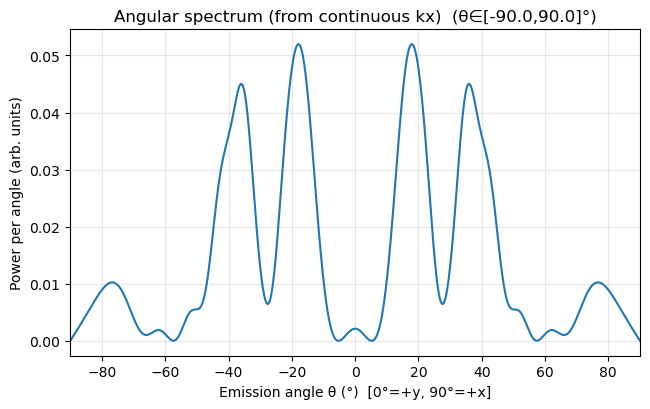

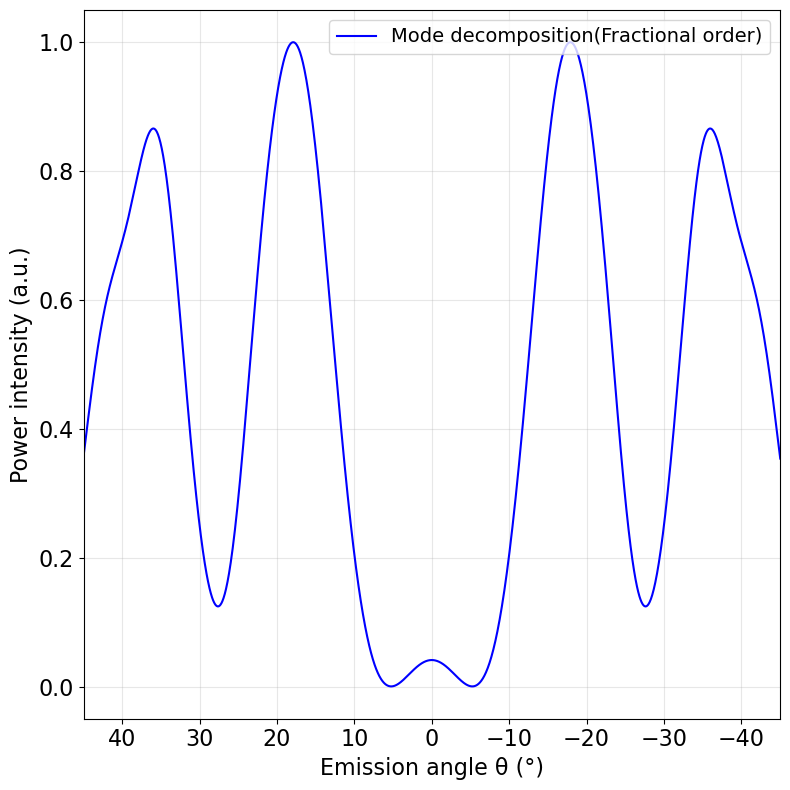

In [190]:
dft_monitor = opt_list[0].sim.add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)

opt_list[0].plot2D()

opt_list[0].sim.run(until=200)
Ez_dft = opt_list[0].sim.get_dft_array(dft_monitor,mp.Ez,0)

# ================= 물리적 회절차수 스펙트럼(분수/정수) + ANGLE MASK =================
import numpy as np
import matplotlib.pyplot as plt

# -------------------------- 사용자 입력 (예시/치환) --------------------------
# Ez_dft   = np.array(sim.get_dft_array(dft_top, mp.Ez, fi0))  # 이미 갖고 있다고 가정
# resolution = 50
# f0       = 1.429                      # 1/µm
# Lambda   = 1.0                        # µm, 예시

use_window   = True
win_kind     = 'tukey'                  # 'hann' or 'tukey'
tukey_alpha  = 0.25
Nkx          = 4001
weight       = 'Sy'                     # 'none' 또는 'Sy' (라인 윗면 법선 플럭스 가중)

# === ANGLE MASK ===
USE_ANGLE_MASK = True                  # False로 두면 마스크 비활성화
theta_min_deg  = -90                 # 보고 싶은 각도 범위(도)
theta_max_deg  = +90

# ------------------------------ 전처리 ------------------------------
Ez = Ez_dft.astype(np.complex128)
N  = len(Ez)
dx = 1.0 / float(resolution)

def make_window(N, kind='tukey', alpha=0.25):
    if kind.lower() in ['hann','hanning']:
        return np.hanning(N)
    if kind.lower() in ['tukey','tuk']:
        if alpha <= 0:  return np.ones(N)
        if alpha >= 1:  return np.hanning(N)
        n = np.arange(N)
        w = np.ones(N)
        edge = int(alpha*(N-1)/2.0)
        m = n[:edge+1]
        w[:edge+1] = 0.5*(1+np.cos(np.pi*(2*m/(alpha*(N-1)) - 1)))
        m = n[-(edge+1):]
        w[-(edge+1):] = 0.5*(1+np.cos(np.pi*(2*(m-(N-1))/(alpha*(N-1)) + 1)))
        return w
    return np.ones(N)

w = make_window(N, win_kind, tukey_alpha) if use_window else np.ones(N)

# 좌표는 중심 기준(위상 안정)
x      = (np.arange(N) - (N-1)/2) * dx
Ez_win = Ez * w

# ----------------------- 물리 상수/격자 파라미터 -----------------------
k0     = 2*np.pi*float(fcen)        # n=1 가정(Meep 기본 단위)
G      = 2*np.pi/float(1/fcen)    # 역격자 크기
m_max  = int(np.floor(k0/G + 1e-12))
m_list = np.arange(-m_max, m_max+1)

# -------------------- 연속 kx 그리드에서 직접 DFT --------------------
kx_grid = np.linspace(-k0, +k0, Nkx)     # 전파 성분 영역
Ckx     = dx * np.sum(Ez_win[:,None] * np.exp(-1j * x[:,None] * kx_grid), axis=0)
m_grid  = kx_grid / G

# === ANGLE MASK 생성 ===
theta_all = np.degrees(np.arcsin(np.clip(kx_grid/k0, -1, 1)))   # 0°=정면(+y), +90°=+x
if USE_ANGLE_MASK:
    ang_mask = (theta_all >= theta_min_deg) & (theta_all <= theta_max_deg)
else:
    ang_mask = np.ones_like(theta_all, dtype=bool)

# 마스크 적용된 그리드/스펙트럼
kx_masked   = kx_grid[ang_mask]
m_masked    = m_grid[ang_mask]
Ckx_masked  = Ckx[ang_mask]
theta_masked= theta_all[ang_mask]

# -------------------- (1) 분수차수 포함 스펙트럼 --------------------
plt.figure(figsize=(6.6,4.2))
plt.plot(m_masked, np.abs(Ckx_masked)**2)
plt.xlim(-max(5, m_max+1), max(5, m_max+1))
plt.xlabel("Diffraction order m  (fractional allowed)")
plt.ylabel(r"$|E(k_x)|^2$  (arb. units)")
title_mask = f"  (θ∈[{theta_min_deg:.1f},{theta_max_deg:.1f}]°)" if USE_ANGLE_MASK else ""
plt.title("Fractional-order spectrum"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (2) 정수 차수별 파워(구간 적분) --------------------
Pk = []
dk = kx_grid[1] - kx_grid[0]
for m_int in m_list:
    k_lo = (m_int - 0.5)*G
    k_hi = (m_int + 0.5)*G
    # 전파영역과 교집합만
    k_lo = max(k_lo, -k0)
    k_hi = min(k_hi, +k0)
    if k_hi <= k_lo:
        Pk.append(0.0)
        continue
    # 각 차수 구간 + ANGLE MASK 동시 적용
    sel = (kx_grid >= k_lo) & (kx_grid < k_hi) & ang_mask
    if not np.any(sel):
        Pk.append(0.0)
        continue
    if weight.lower() == 'sy':
        ky = np.sqrt(np.maximum(k0**2 - kx_grid[sel]**2, 0.0))
        P_m = np.sum(np.abs(Ckx[sel])**2 * (ky/k0)) * dk   # 윗면 법선 플럭스 가중
    else:
        P_m = np.sum(np.abs(Ckx[sel])**2) * dk             # 무가중
    Pk.append(P_m)

Pk = np.array(Pk, dtype=float)

# stem 대신 vlines+scatter(버전 호환)
plt.figure(figsize=(6.6,4.2))
plt.vlines(m_list, 0.0, Pk, colors='C0', linewidth=1.6)
plt.plot(m_list, Pk, 'C0o', ms=6)
plt.xlabel("Diffraction order m (integer)")
plt.ylabel("Power per order (arb. units)")
plt.title(f"Discrete order power (weight='{weight}'){title_mask}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (3) 각도 스펙트럼(참고) --------------------
# 각도당 전력
if weight.lower() == 'sy':
    P_theta = np.abs(Ckx_masked)**2 * np.sqrt(np.maximum(0,1-(kx_masked/k0)**2))  # = |E|^2 cosθ
else:
    P_theta = np.abs(Ckx_masked)**2

plt.figure(figsize=(6.6,4.2))
plt.plot(theta_masked, P_theta)
plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)  [0°=+y, 90°=+x]")
plt.ylabel("Power per angle (arb. units)")
plt.title("Angular spectrum (from continuous kx)"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# =============================================================================

plt.figure(figsize=(8,8))
plt.plot(theta_masked, P_theta/max(P_theta), 'b-', label = 'Mode decomposition(Fractional order)')
# plt.plot(angle_sel,Pr_sel, 'r-', label = 'N2F - 360 points')

plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize = 16)
plt.ylabel("Power intensity (a.u.)",fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(45, -45)

plt.grid(True, alpha=0.3)
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()
plt.show()


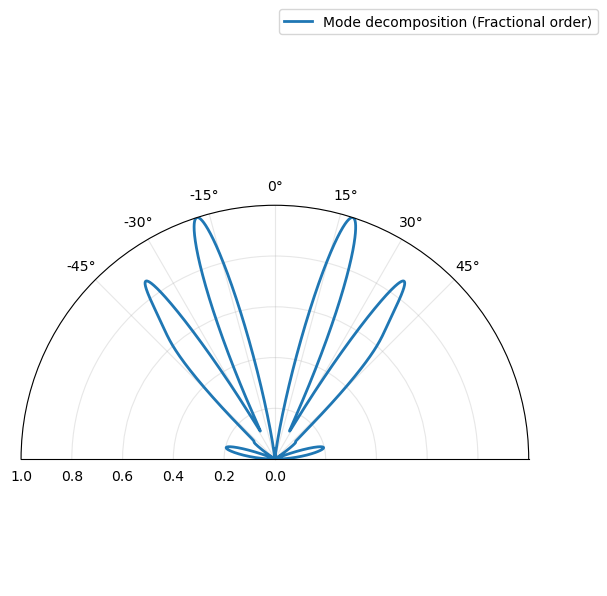

In [191]:
th1 = np.radians(theta_masked)
y1  = P_theta / np.max(P_theta)

# th2 = np.radians(angle_sel)
# y2  = Pr_sel / np.max(Pr_sel)  # 이미 정규화되어 있으면 생략

fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='polar')

# 각도 기준/방향 설정
ax.set_theta_zero_location('N')   # 0°를 위쪽으로
ax.set_theta_direction(-1)        # 시계 방향으로 증가

# 반폴라 범위: −45° ~ +45°
ax.set_thetamin(-90)
ax.set_thetamax(90)
# (버전에 따라) ax.set_thetalim(np.radians((-45, 45))) 사용 가능

# 곡선 플롯
ax.plot(th1, y1, label='Mode decomposition (Fractional order)', linewidth=2)
# ax.plot(th2, y2, label = 'N2F - 360 points', linewidth=2)

# 반경 범위/눈금
ax.set_rlim(0, 1)
ax.set_thetagrids(range(-45, 46, 15))
ax.grid(True, alpha=0.3)

ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
plt.tight_layout()
plt.show()

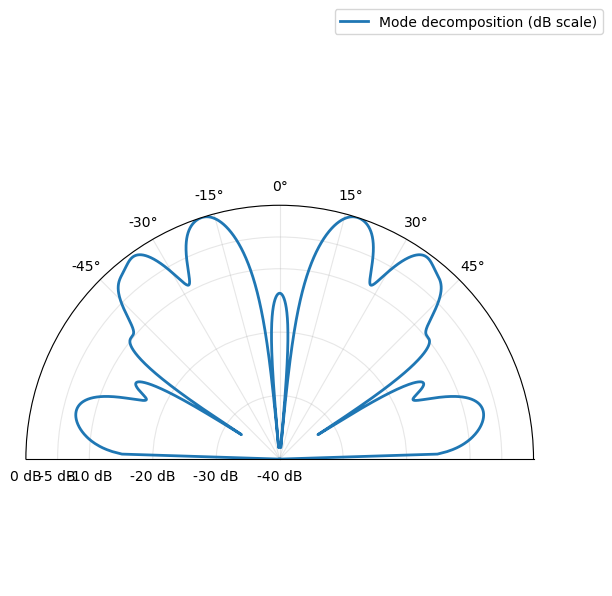

In [192]:
eps = 1e-15

# 각도(라디안)
th1 = np.radians(theta_masked)

# 파워 정규화 후 dB 변환 (0 dB = max)
P_norm = P_theta / (np.max(P_theta) + eps)
y_db   = 10.0 * np.log10(P_norm + eps)          # <= 0 dB

# 표시 하한(dB) 설정 및 클리핑
db_floor = -40.0                                 # 필요시 -30~-60 dB로 조정
y_db_clip = np.maximum(y_db, db_floor)

# dB → 반지름(0~1) 매핑 (라벨은 dB로 표시)
r = (y_db_clip - db_floor) / (0.0 - db_floor)    # db_floor -> 0, 0dB -> 1

fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='polar')

# 각도 기준/방향
ax.set_theta_zero_location('N')   # 0° 위쪽
ax.set_theta_direction(-1)        # 시계방향 증가

# 보이는 각도 범위는 그대로 -90° ~ 90°
ax.set_thetamin(-90)
ax.set_thetamax(90)

# 플롯
ax.plot(th1, r, label='Mode decomposition (dB scale)', linewidth=2)

# 반지름 범위 0~1 고정
ax.set_rlim(0, 1)

# dB 라벨 표시: 원하는 눈금(dB)을 반지름으로 변환
tick_dB = np.array([0, -5, -10, -20, -30, db_floor])
tick_r  = (tick_dB - db_floor) / (0.0 - db_floor)
ax.set_yticks(tick_r)
ax.set_yticklabels([f"{v:.0f} dB" for v in tick_dB])

# 각도 눈금/그리드
ax.set_thetagrids(range(-45, 46, 15))
ax.grid(True, alpha=0.3)

ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
plt.tight_layout()
plt.show()


최대 FoM = 15930.859671 는 iteration 149 에서 나왔습니다.


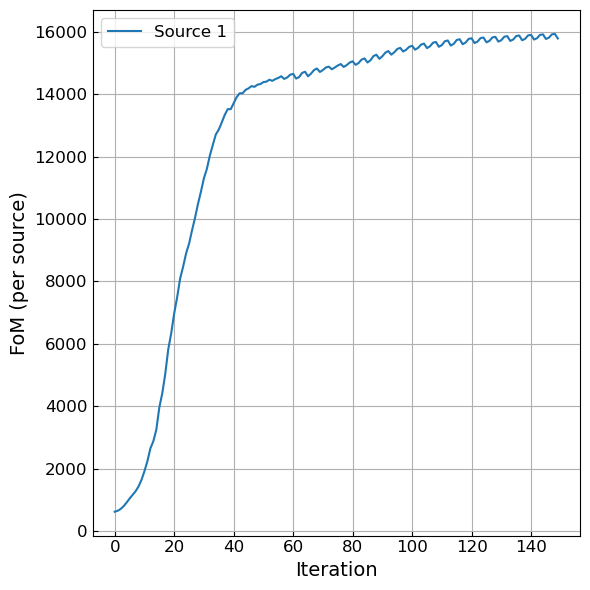

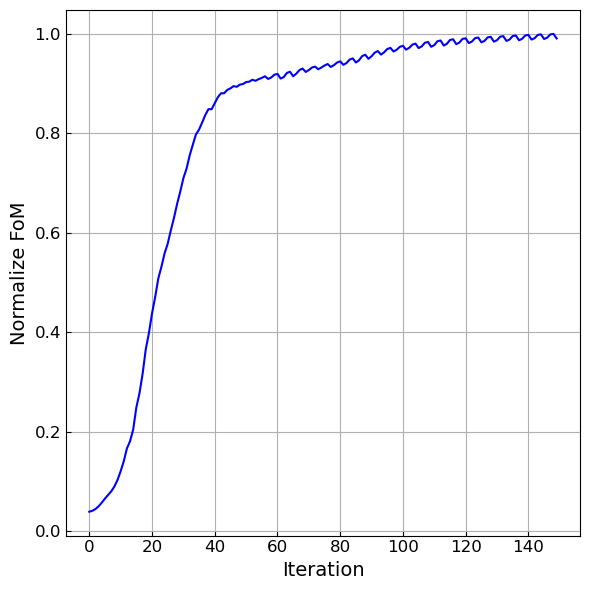

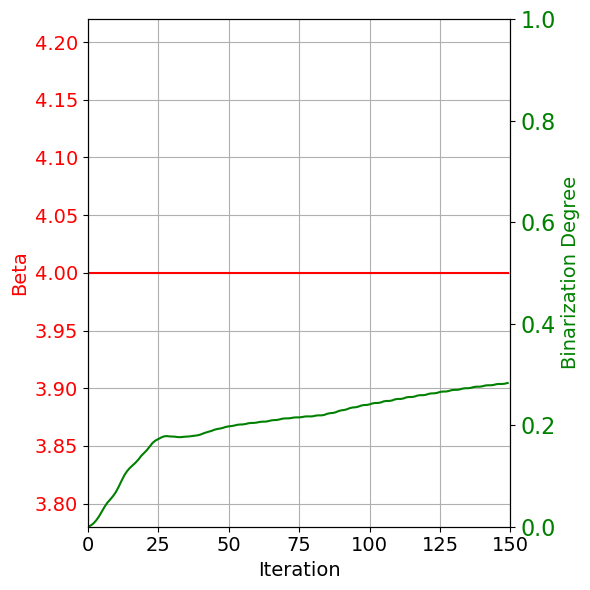

In [71]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
evaluation_array = np.array(evaluation_history)  
iterations = np.arange(len(evaluation_history))

###################### [1] 각 소스별 FoM plot ######################
plt.figure(figsize=(6, 6))

for i in range(evaluation_array.shape[1]):  # 각 소스별
    plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('FoM (per source)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###################### [2] 평균 FoM plot ######################
plt.figure(figsize=(6, 6))

mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
plt.plot(iterations, mean_fom/max(mean_fom), 'b-', label='Mean FoM')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Normalize FoM', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.tight_layout()
plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()

최대 FoM = 15467.690055 는 iteration 114 에서 나왔습니다.


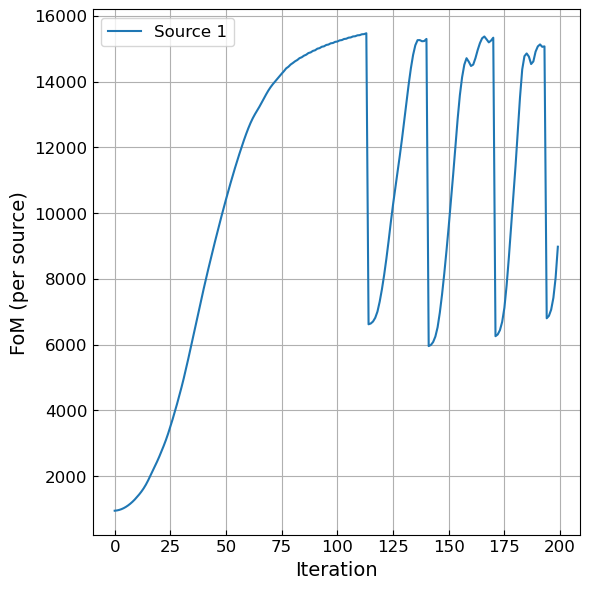

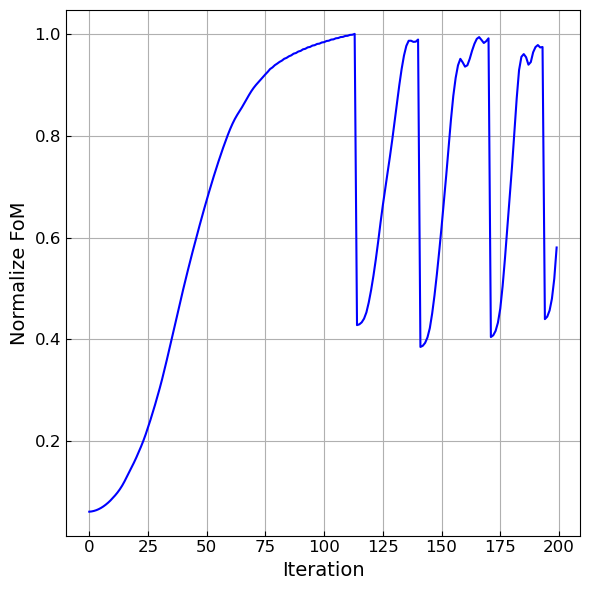

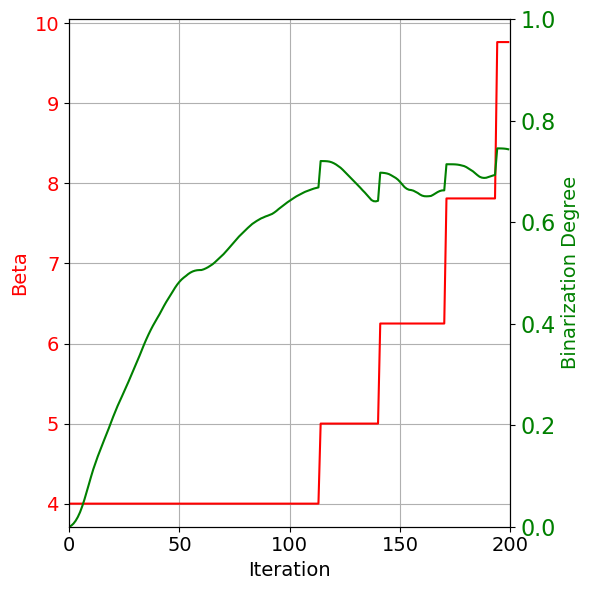

In [ ]:
# ################ Find best FOM ################ 
# eval_hist = np.array(evaluation_history)
# max_val   = eval_hist.max()
# max_idx0  = eval_hist.argmax()
# iteration = max_idx0 + 1

# print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

# ################ FOM plot ################ 
# evaluation_array = np.array(evaluation_history)  
# iterations = np.arange(len(evaluation_history))

# ###################### [1] 각 소스별 FoM plot ######################
# plt.figure(figsize=(6, 6))

# for i in range(evaluation_array.shape[1]):  # 각 소스별
#     plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

# plt.xlabel('Iteration', fontsize=14)
# plt.ylabel('FoM (per source)', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tick_params(direction='in')
# plt.grid(True)
# plt.legend(fontsize=12)
# plt.tight_layout()
# plt.show()

# ###################### [2] 평균 FoM plot ######################
# plt.figure(figsize=(6, 6))

# mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
# plt.plot(iterations, mean_fom/max(mean_fom), 'b-', label='Mean FoM')

# plt.xlabel('Iteration', fontsize=14)
# plt.ylabel('Normalize FoM', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tick_params(direction='in')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# ################ Combined Beta and Binarization Degree Plot ################ 
# fig, ax1 = plt.subplots(figsize=(6,6))

# color1 = 'red'
# ax1.set_xlabel('Iteration', fontsize=14)
# ax1.set_ylabel('Beta', color=color1, fontsize=14)
# ax1.plot(beta_history, color=color1, label='Beta History')
# ax1.tick_params(axis='y', labelcolor=color1)
# ax1.set_xlim(0, np.array(cur_iter))
# ax1.tick_params(labelsize=14)
# ax1.grid(True)

# ax2 = ax1.twinx()
# color2 = 'green'
# ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
# ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
# ax2.tick_params(axis='y', labelcolor=color2)
# ax2.set_ylim(0.4, 1)
# ax2.set_ylim(0, 1)
# ax2.tick_params(labelsize=16)

# fig.tight_layout()
# # plt.title('Beta & Binarization Degree', fontsize=15)
# plt.show()

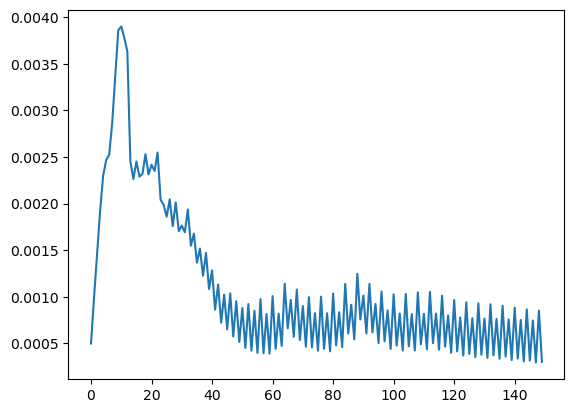

In [95]:
plt.plot(np.array(lr_histories)[0])

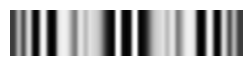

In [72]:
plt.figure(figsize=(3, 2))
ax = plt.gca()
opt_list[0].plot2D(
    False,
    output_plane=mp.Volume(
        size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
        center=mp.Vector3(0, full_center_y, 0)
    ),
    ax=ax,
    show_sources=False,
    show_monitors=False,
    show_boundary_layers=False,
)
ax.axis("off")
plt.show()

In [ ]:
# k = design_variables.weights
# np.savetxt("Objective45.txt", k) 

In [89]:
k = np.loadtxt("Objective45.txt")
opt_list[0].update_design([k])

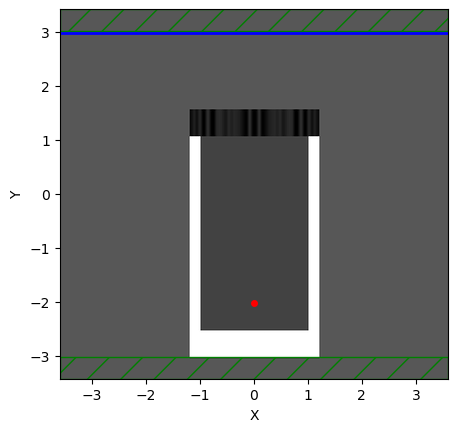

In [90]:
dft_monitor = opt_list[0].sim.add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)

opt_list[0].plot2D()

In [91]:
opt_list[0].sim.run(until=200)
Ez_dft = opt_list[0].sim.get_dft_array(dft_monitor,mp.Ez,0)

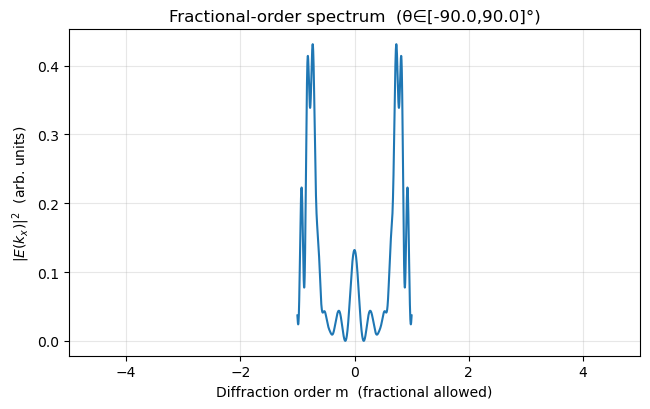

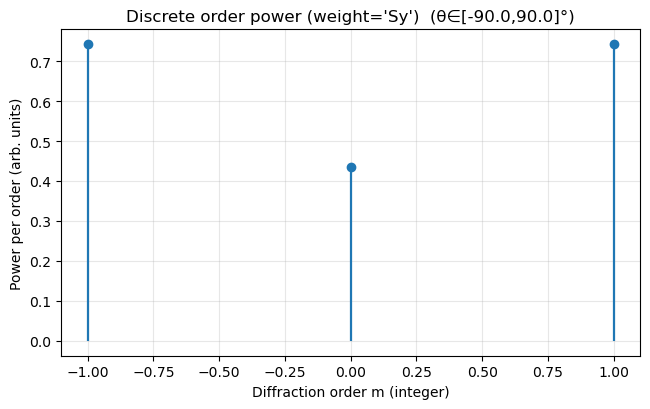

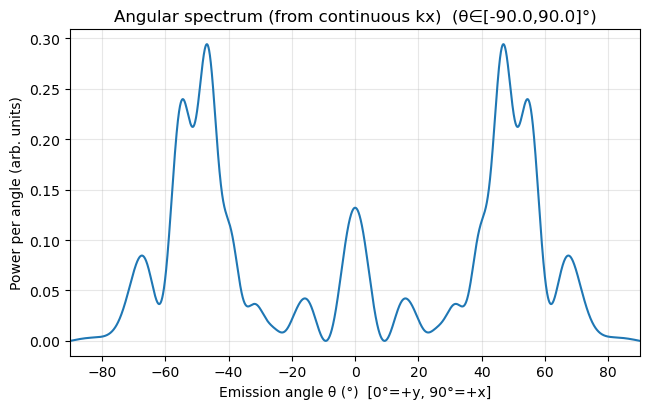

In [92]:
# ================= 물리적 회절차수 스펙트럼(분수/정수) + ANGLE MASK =================
import numpy as np
import matplotlib.pyplot as plt

# -------------------------- 사용자 입력 (예시/치환) --------------------------
# Ez_dft   = np.array(sim.get_dft_array(dft_top, mp.Ez, fi0))  # 이미 갖고 있다고 가정
# resolution = 50
# f0       = 1.429                      # 1/µm
# Lambda   = 1.0                        # µm, 예시

use_window   = True
win_kind     = 'tukey'                  # 'hann' or 'tukey'
tukey_alpha  = 0.25
Nkx          = 4001
weight       = 'Sy'                     # 'none' 또는 'Sy' (라인 윗면 법선 플럭스 가중)

# === ANGLE MASK ===
USE_ANGLE_MASK = True                  # False로 두면 마스크 비활성화
theta_min_deg  = -90                 # 보고 싶은 각도 범위(도)
theta_max_deg  = +90

# ------------------------------ 전처리 ------------------------------
Ez = Ez_dft.astype(np.complex128)
N  = len(Ez)
dx = 1.0 / float(resolution)

def make_window(N, kind='tukey', alpha=0.25):
    if kind.lower() in ['hann','hanning']:
        return np.hanning(N)
    if kind.lower() in ['tukey','tuk']:
        if alpha <= 0:  return np.ones(N)
        if alpha >= 1:  return np.hanning(N)
        n = np.arange(N)
        w = np.ones(N)
        edge = int(alpha*(N-1)/2.0)
        m = n[:edge+1]
        w[:edge+1] = 0.5*(1+np.cos(np.pi*(2*m/(alpha*(N-1)) - 1)))
        m = n[-(edge+1):]
        w[-(edge+1):] = 0.5*(1+np.cos(np.pi*(2*(m-(N-1))/(alpha*(N-1)) + 1)))
        return w
    return np.ones(N)

w = make_window(N, win_kind, tukey_alpha) if use_window else np.ones(N)

# 좌표는 중심 기준(위상 안정)
x      = (np.arange(N) - (N-1)/2) * dx
Ez_win = Ez * w

# ----------------------- 물리 상수/격자 파라미터 -----------------------
k0     = 2*np.pi*float(fcen)        # n=1 가정(Meep 기본 단위)
G      = 2*np.pi/float(1/fcen)    # 역격자 크기
m_max  = int(np.floor(k0/G + 1e-12))
m_list = np.arange(-m_max, m_max+1)

# -------------------- 연속 kx 그리드에서 직접 DFT --------------------
kx_grid = np.linspace(-k0, +k0, Nkx)     # 전파 성분 영역
Ckx     = dx * np.sum(Ez_win[:,None] * np.exp(-1j * x[:,None] * kx_grid), axis=0)
m_grid  = kx_grid / G

# === ANGLE MASK 생성 ===
theta_all = np.degrees(np.arcsin(np.clip(kx_grid/k0, -1, 1)))   # 0°=정면(+y), +90°=+x
if USE_ANGLE_MASK:
    ang_mask = (theta_all >= theta_min_deg) & (theta_all <= theta_max_deg)
else:
    ang_mask = np.ones_like(theta_all, dtype=bool)

# 마스크 적용된 그리드/스펙트럼
kx_masked   = kx_grid[ang_mask]
m_masked    = m_grid[ang_mask]
Ckx_masked  = Ckx[ang_mask]
theta_masked= theta_all[ang_mask]

# -------------------- (1) 분수차수 포함 스펙트럼 --------------------
plt.figure(figsize=(6.6,4.2))
plt.plot(m_masked, np.abs(Ckx_masked)**2)
plt.xlim(-max(5, m_max+1), max(5, m_max+1))
plt.xlabel("Diffraction order m  (fractional allowed)")
plt.ylabel(r"$|E(k_x)|^2$  (arb. units)")
title_mask = f"  (θ∈[{theta_min_deg:.1f},{theta_max_deg:.1f}]°)" if USE_ANGLE_MASK else ""
plt.title("Fractional-order spectrum"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (2) 정수 차수별 파워(구간 적분) --------------------
Pk = []
dk = kx_grid[1] - kx_grid[0]
for m_int in m_list:
    k_lo = (m_int - 0.5)*G
    k_hi = (m_int + 0.5)*G
    # 전파영역과 교집합만
    k_lo = max(k_lo, -k0)
    k_hi = min(k_hi, +k0)
    if k_hi <= k_lo:
        Pk.append(0.0)
        continue
    # 각 차수 구간 + ANGLE MASK 동시 적용
    sel = (kx_grid >= k_lo) & (kx_grid < k_hi) & ang_mask
    if not np.any(sel):
        Pk.append(0.0)
        continue
    if weight.lower() == 'sy':
        ky = np.sqrt(np.maximum(k0**2 - kx_grid[sel]**2, 0.0))
        P_m = np.sum(np.abs(Ckx[sel])**2 * (ky/k0)) * dk   # 윗면 법선 플럭스 가중
    else:
        P_m = np.sum(np.abs(Ckx[sel])**2) * dk             # 무가중
    Pk.append(P_m)

Pk = np.array(Pk, dtype=float)

# stem 대신 vlines+scatter(버전 호환)
plt.figure(figsize=(6.6,4.2))
plt.vlines(m_list, 0.0, Pk, colors='C0', linewidth=1.6)
plt.plot(m_list, Pk, 'C0o', ms=6)
plt.xlabel("Diffraction order m (integer)")
plt.ylabel("Power per order (arb. units)")
plt.title(f"Discrete order power (weight='{weight}'){title_mask}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (3) 각도 스펙트럼(참고) --------------------
# 각도당 전력
if weight.lower() == 'sy':
    P_theta = np.abs(Ckx_masked)**2 * np.sqrt(np.maximum(0,1-(kx_masked/k0)**2))  # = |E|^2 cosθ
else:
    P_theta = np.abs(Ckx_masked)**2

plt.figure(figsize=(6.6,4.2))
plt.plot(theta_masked, P_theta)
plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)  [0°=+y, 90°=+x]")
plt.ylabel("Power per angle (arb. units)")
plt.title("Angular spectrum (from continuous kx)"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# =============================================================================


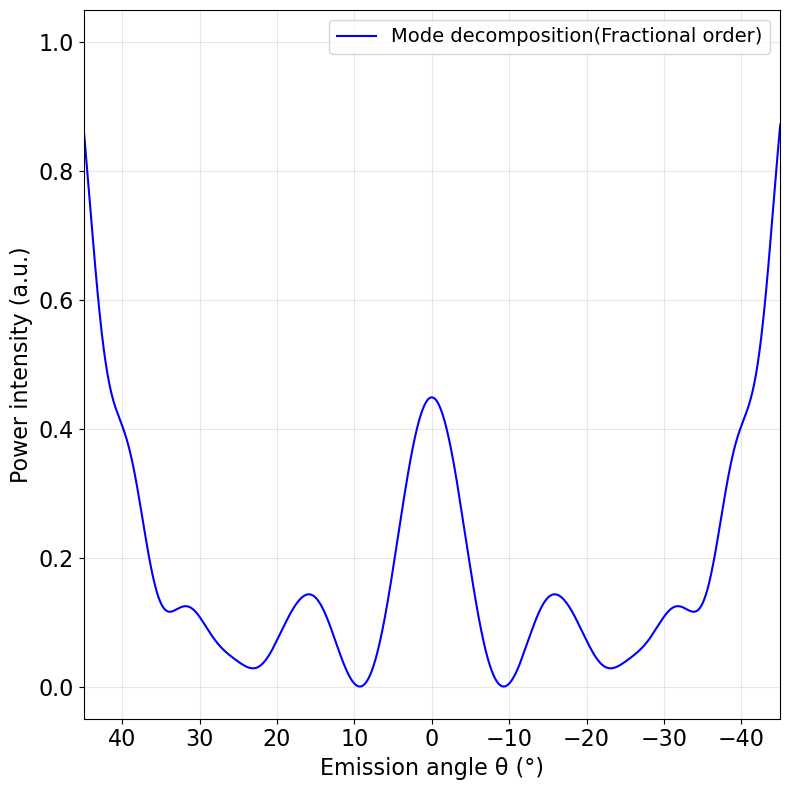

In [93]:
plt.figure(figsize=(8,8))
plt.plot(theta_masked, P_theta/max(P_theta), 'b-', label = 'Mode decomposition(Fractional order)')
# plt.plot(angle_sel,Pr_sel, 'r-', label = 'N2F - 360 points')

plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize = 16)
plt.ylabel("Power intensity (a.u.)",fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(45, -45)

plt.grid(True, alpha=0.3)
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()
plt.show()

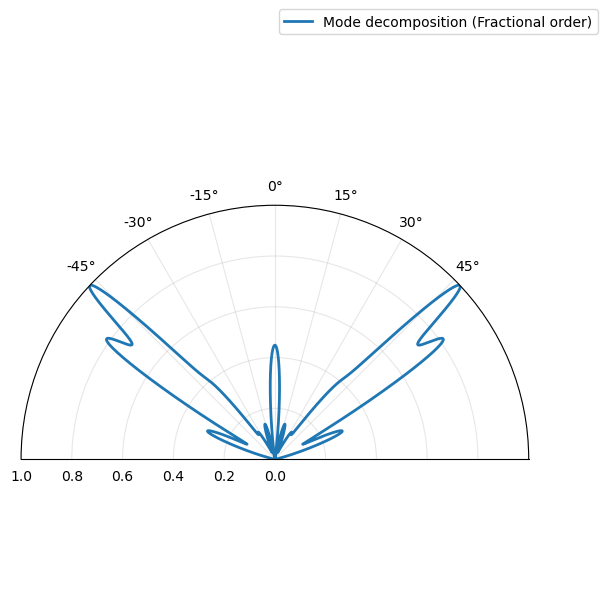

In [94]:
th1 = np.radians(theta_masked)
y1  = P_theta / np.max(P_theta)

# th2 = np.radians(angle_sel)
# y2  = Pr_sel / np.max(Pr_sel)  # 이미 정규화되어 있으면 생략

fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='polar')

# 각도 기준/방향 설정
ax.set_theta_zero_location('N')   # 0°를 위쪽으로
ax.set_theta_direction(-1)        # 시계 방향으로 증가

# 반폴라 범위: −45° ~ +45°
ax.set_thetamin(-90)
ax.set_thetamax(90)
# (버전에 따라) ax.set_thetalim(np.radians((-45, 45))) 사용 가능

# 곡선 플롯
ax.plot(th1, y1, label='Mode decomposition (Fractional order)', linewidth=2)
# ax.plot(th2, y2, label = 'N2F - 360 points', linewidth=2)

# 반경 범위/눈금
ax.set_rlim(0, 1)
ax.set_thetagrids(range(-45, 46, 15))
ax.grid(True, alpha=0.3)

ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
plt.tight_layout()
plt.show()

In [118]:
Pr_sel = [0.0107073 , 0.00997911, 0.00929179, 0.00858321, 0.00785196,
       0.00722387, 0.00693566, 0.00724677, 0.00835336, 0.01038169,
       0.01347349, 0.01789102, 0.02403943, 0.03236102, 0.04316205,
       0.0564946 , 0.07217363, 0.08989717, 0.10936095, 0.13028385,
       0.15235092, 0.17514219, 0.19810081, 0.22053809, 0.24164224,
       0.26047998, 0.27603237, 0.28733134, 0.29371606, 0.2951224 ,
       0.29224894, 0.2864981 , 0.27973519, 0.27399191, 0.27119093,
       0.27288426, 0.28001228, 0.2927724 , 0.31069091, 0.33286859,
       0.35826124, 0.38590484, 0.41512142, 0.44574314, 0.4782618 ,
       0.51376432, 0.55364272, 0.59920532, 0.6512954 , 0.70989836,
       0.77367305, 0.83946941, 0.90209251, 0.95463614, 0.9895187 ,
       1.        , 0.98168908, 0.93357025, 0.85832738, 0.76198554,
       0.65296501, 0.54066679, 0.43384086, 0.33915452, 0.26035653,
       0.19818285, 0.15089904, 0.11529506, 0.08794246, 0.06642097,
       0.05008402, 0.03999509, 0.0380118 , 0.04541254, 0.06166677,
       0.08385958, 0.10702342, 0.12534793, 0.13396979, 0.13080257,
       0.11774194, 0.10069413, 0.08824102, 0.08923717, 0.11003104,
       0.15216666, 0.21131345, 0.27783662, 0.33894995, 0.38191171,
       0.39737496, 0.38191171, 0.33894995, 0.27783662, 0.21131345,
       0.15216666, 0.11003104, 0.08923717, 0.08824102, 0.10069413,
       0.11774194, 0.13080257, 0.13396979, 0.12534793, 0.10702342,
       0.08385958, 0.06166677, 0.04541254, 0.0380118 , 0.03999509,
       0.05008402, 0.06642097, 0.08794246, 0.11529506, 0.15089904,
       0.19818285, 0.26035653, 0.33915452, 0.43384086, 0.54066679,
       0.65296501, 0.76198554, 0.85832738, 0.93357025, 0.98168908,
       1.        , 0.9895187 , 0.95463614, 0.90209251, 0.83946941,
       0.77367305, 0.70989836, 0.6512954 , 0.59920532, 0.55364272,
       0.51376432, 0.4782618 , 0.44574314, 0.41512142, 0.38590484,
       0.35826124, 0.33286859, 0.31069091, 0.2927724 , 0.28001228,
       0.27288426, 0.27119093, 0.27399191, 0.27973519, 0.2864981 ,
       0.29224894, 0.2951224 , 0.29371606, 0.28733134, 0.27603237,
       0.26047998, 0.24164224, 0.22053809, 0.19810081, 0.17514219,
       0.15235092, 0.13028385, 0.10936095, 0.08989717, 0.07217363,
       0.0564946 , 0.04316205, 0.03236102, 0.02403943, 0.01789102,
       0.01347349, 0.01038169, 0.00835336, 0.00724677, 0.00693566,
       0.00722387, 0.00785196, 0.00858321, 0.00929179, 0.00997911,
       0.0107073 ]
angle_sel = [
    -90., -89., -88., -87., -86., -85., -84., -83., -82., -81., -80.,
       -79., -78., -77., -76., -75., -74., -73., -72., -71., -70., -69.,
       -68., -67., -66., -65., -64., -63., -62., -61., -60., -59., -58.,
       -57., -56., -55., -54., -53., -52., -51., -50., -49., -48., -47.,
       -46., -45., -44., -43., -42., -41., -40., -39., -38., -37., -36.,
       -35., -34., -33., -32., -31., -30., -29., -28., -27., -26., -25.,
       -24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14.,
       -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
        -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
         9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
        20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
        64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,
        75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,
        86.,  87.,  88.,  89.,  90.
]

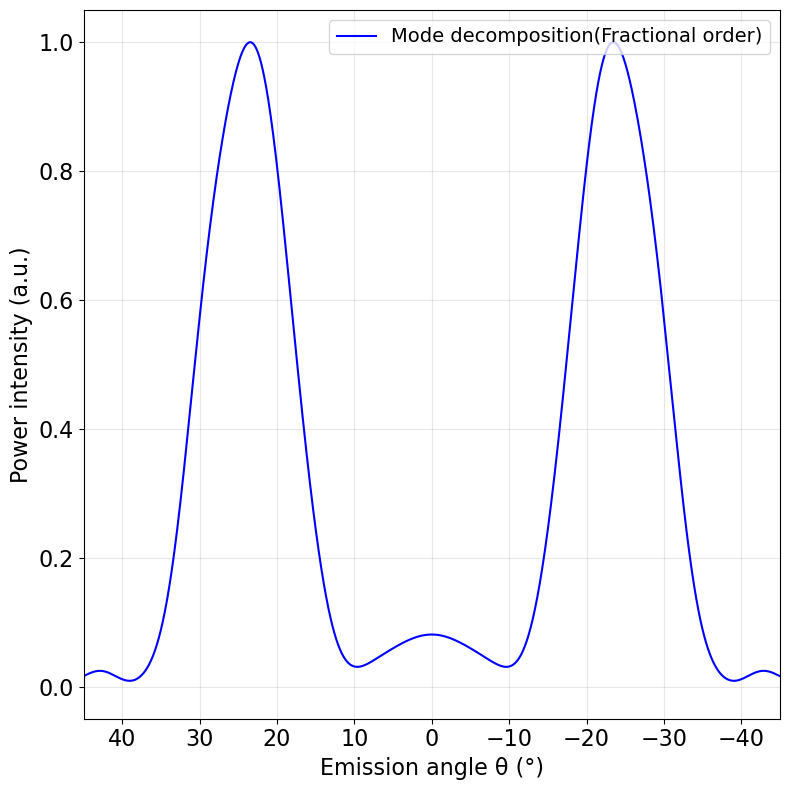

In [64]:
plt.figure(figsize=(8,8))
plt.plot(theta_masked, P_theta/max(P_theta), 'b-', label = 'Mode decomposition(Fractional order)')
# plt.plot(angle_sel,Pr_sel, 'r-', label = 'N2F - 360 points')

plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize = 16)
plt.ylabel("Power intensity (a.u.)",fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(45, -45)

plt.grid(True, alpha=0.3)
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()
plt.show()

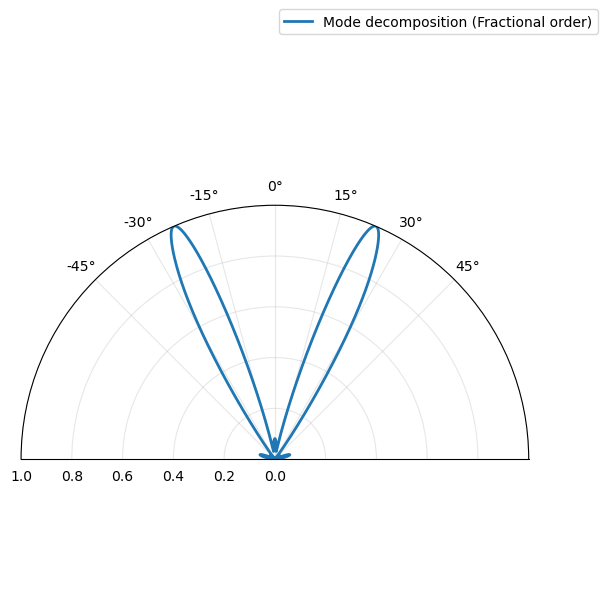

In [66]:
th1 = np.radians(theta_masked)
y1  = P_theta / np.max(P_theta)

# th2 = np.radians(angle_sel)
# y2  = Pr_sel / np.max(Pr_sel)  # 이미 정규화되어 있으면 생략

fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='polar')

# 각도 기준/방향 설정
ax.set_theta_zero_location('N')   # 0°를 위쪽으로
ax.set_theta_direction(-1)        # 시계 방향으로 증가

# 반폴라 범위: −45° ~ +45°
ax.set_thetamin(-90)
ax.set_thetamax(90)
# (버전에 따라) ax.set_thetalim(np.radians((-45, 45))) 사용 가능

# 곡선 플롯
ax.plot(th1, y1, label='Mode decomposition (Fractional order)', linewidth=2)
# ax.plot(th2, y2, label = 'N2F - 360 points', linewidth=2)

# 반경 범위/눈금
ax.set_rlim(0, 1)
ax.set_thetagrids(range(-45, 46, 15))
ax.grid(True, alpha=0.3)

ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
plt.tight_layout()
plt.show()